In [189]:

import pandas as pd
import numpy as np
import numpy.random as npr 
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm


# Initialisation du Problème, création d'un dataset 

In [208]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

K = 4
# Créez un ensemble de données avec 1000 échantillons, 20 caractéristiques et 2 classes pour la variable cible
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, n_classes=K, random_state=0)
# n_informative : nombre de caractéristiques informatives, celles qui sont réellement utiles pour prédire la classe cible.
# n_redundant : nombre de caractéristiques redondantes générées comme des combinaisons linéaires des caractéristiques informatives.

X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.2)

In [141]:
# Vérification que les groupes sont équilibrés :

for i in range(4):
    print(len(Y_train[Y_train==i])/len(Y_train))

0.255
0.2425
0.2425
0.26


# Création d'un premier modèle d'arbre de classification peu performant

In [148]:
#Premier modèle d'arbre sous certaines contraintes

clf = DecisionTreeClassifier(criterion='entropy',max_depth=10,ccp_alpha=0.03)

clf.fit(X_train, Y_train)

X_pred_train = clf.predict(X_train)
X_pred_test = clf.predict(X_test)

print('accuracy score train', accuracy_score(X_pred_train,Y_train))
print('accuracy score test', accuracy_score(X_pred_test,Y_test))

clf.predict_proba(X_train[i].reshape(1, -1)).shape

accuracy score train 0.5775
accuracy score test 0.53


(1, 4)

J'ai essayé de faire plusieurs tests pour la programmation de l'algorithme d'arbre par gradient boosting au vu de ma compréhension du cours. 

# Native gradient boosting Test 0

In [143]:
# y is a category and z is a vector of R^K, Z=F(x) 
K=4

def pi(k,z):
    return np.exp(z[k])/np.exp(z).sum()

def psi(y,z):
    return -np.log(pi(y,z))

def grad_psi(y,z):
    grad = np.zeros(len(z))
    grad[y] = -1
    for k in range(len(z)):
        grad[k] += pi(k,z)
    return grad

def Cn(F,Y,X):
    n = len(Y)
    cost = np.array([ psi(Y[i],F(X[i])) for i in range(n) ])
    return cost.sum()/n

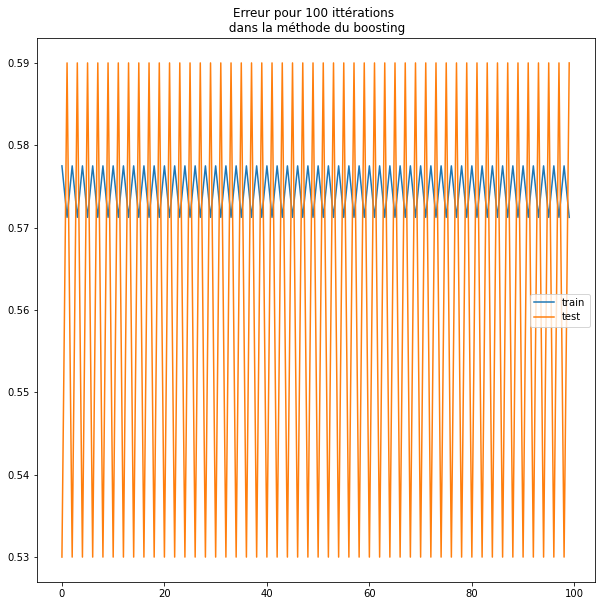

In [166]:
def boosting_tree_classifie(X_train,X_test,Y_train,Y_test,clf,it=10,etha=0.01,display=True):
    n = len(Y_train) 
    Err_train = []
    Err_test = []
    W = np.ones(n)/n 
    
    for k in range(1,it+1):
        model= clf.fit(X_train, Y_train,sample_weight=W)

        Y_pred_train = model.predict(X_train)
        Y_pred_test = model.predict(X_test)
        
        #Chargement de l'erreur de prédiction avec ce modèle Bootstrap
        Err_train.append(accuracy_score(Y_pred_train,Y_train))
        Err_test.append(accuracy_score(Y_pred_test,Y_test))
        
        #Chargement des poids et attribution des des nouveaux poids
        for i in range(n):    
            W[i] =1 - pi(Y_train[i] , model.predict_proba(X_train[i].reshape(1, -1)).flatten() ) #correspond au 
               
    if display:
        plt.figure(figsize=(10,10))
        plt.plot(Err_train,label='train')
        plt.plot(Err_test,label='test')
        plt.title(f'Erreur pour {it} ittérations \n dans la méthode du boosting')
        plt.legend()
        plt.show()
        
    
boosting_tree_classifie(X_train,X_test,Y_train,Y_test,clf,it=100,etha=0.001,display=True)

# Native gradient boosting Test 1

In [ ]:
# y is a category and z is a vector of R^K, Z=F(x) 
K=4

def pi(k,z):
    return np.exp(z[k])/np.exp(z).sum()

def psi(y,z):
    return -np.log(pi(y,z))

def grad_psi(y,z):
    grad = np.zeros(len(z))
    grad[y] = -1
    for k in range(len(z)):
        grad[k] += pi(k,z)
    return grad

def Cn(F,Y,X):
    n = len(Y)
    cost = np.array([ psi(Y[i],F(X[i])) for i in range(n) ])
    return cost.sum()/n

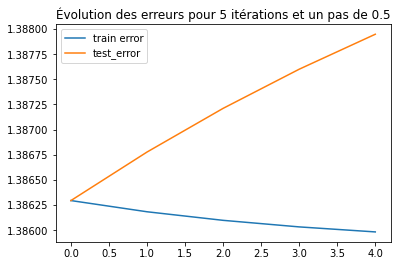

In [180]:

def GB(X_train, X_test, Y_train, Y_test, eta=0.01, it=1,display = True):
    Err_train = []
    Err_test = []

    updates = []  # Liste pour stocker les mises à jour cumulatives

    # Fonction F initiale
    F_init = lambda x: np.zeros(K)
    
    # Fonction F qui applique toutes les mises à jour, une fonction de R**p dans R**K
    def F(x):
        result = F_init(x)
        for update in updates:
            result += update
        return result

    n = len(Y_train)
    for k in range(it):
        Err_train.append(Cn(F, Y_train, X_train))
        Err_test.append(Cn(F, Y_test, X_test))

        grad_sum_cost = np.zeros(K)
        for i in range(n):
            grad_sum_cost -= grad_psi(Y_train[i], F(X_train[i]))

        grad_mean_cost = grad_sum_cost / n #Correspond au gradient de Cn(Z1,Z2,..,Zn)

        # Ajout de la mise à jour actuelle à la liste des mises à jour
        updates.append(eta * grad_mean_cost)
    
    if display:
        plt.plot(Err_train,label='train error')
        plt.plot(Err_test,label = 'test_error')
        plt.title(f"Évolution des erreurs pour {it} itérations et un pas de {eta}" )
        plt.legend()
        

    return F, Err_train, Err_test

# Exemple d'appel de la fonction
F, Err_train, Err_test = GB(X_train, X_test, Y_train, Y_test, eta=0.5, it=5,display = True)


# Gradient boosting tree test 2

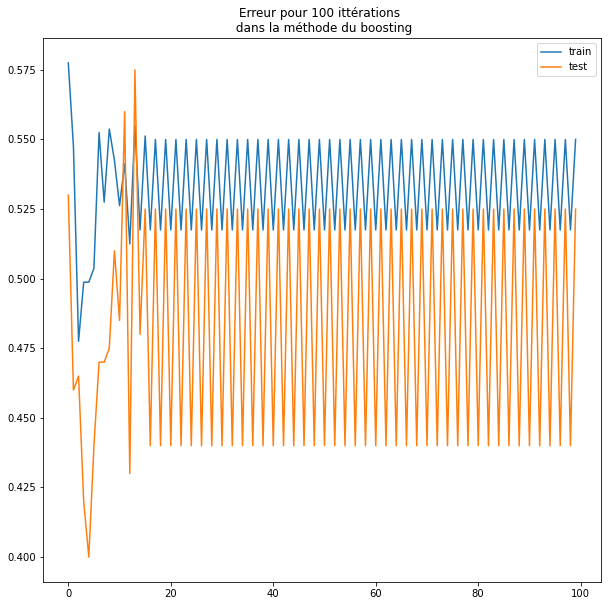

In [181]:
def boosting_tree_classifie(X_train,X_test,Y_train,Y_test,clf,it=10,display=True):
    n = len(Y_train) 
    Err_train = []
    Err_test = []
    W = np.ones(n)/n 
    
    for k in range(1,it+1):
        model= clf.fit(X_train, Y_train,sample_weight=W)

        Y_pred_train = model.predict(X_train)
        Y_pred_test = model.predict(X_test)
        
        #Chargement de l'erreur de prédiction avec ce modèle Bootstrap
        Err_train.append(accuracy_score(Y_pred_train,Y_train))
        Err_test.append(accuracy_score(Y_pred_test,Y_test))
        
        #Chargement des poids et attribution des des nouveaux poids
        if k<it:
            P = model.predict_proba(X_train)
            for i in range(n):
                W[i] = 1 - P[i,Y_train[i]]
               
    if display:
        plt.figure(figsize=(10,10))
        plt.plot(Err_train,label='train')
        plt.plot(Err_test,label='test')
        plt.title(f'Erreur pour {it} ittérations \n dans la méthode du boosting')
        plt.legend()
        plt.show()
        
    
boosting_tree_classifie(X_train,X_test,Y_train,Y_test,clf,it=100,display=True) 

# Gradient boosting tree test 3

In [218]:
# y is a category and z is a vector of R^K, Z=F(x) 
from sklearn.tree import DecisionTreeRegressor

K=4

def pi(k,z):
    return np.exp(z[k])/np.exp(z).sum()

def psi(y,z):
    return -np.log(pi(y,z))

def grad_psi(y,z):
    grad = np.zeros(len(z))
    grad[y] = -1
    for k in range(len(z)):
        grad[k] += pi(k,z)
    return grad

def Cn(F,Y,X):
    n = len(Y)
    cost = np.array([ psi(Y[i],F(X[i])) for i in range(n) ])
    return cost.sum()/n

def predicteur(list_K): #Cette fonction donne une valeur prédite quand elle reçoit un vecteur de taille K
    #Elle calcul l'activation avec la fonction soft_max et prend l'argmax
    list_K = np.array(list_K).flatten()
    return np.array( [np.exp(list_K[k])/np.exp(list_K).sum() for k in range(K)]).argmax()

In [219]:
def predictor(RGT,X):
    n = len(X)
    Z = {f"{k}":[0 for i in range(n)] for k in range(K)}
    Y = np.zeros(n)

    for k in range(K):
        Z[f'{k}'] = RGT[f'{k}'].predict(X)
    
    for i in range(n):
        list_K_i = [Z[f'{k}'][i] for k in range(K)]
        Y[i] = predicteur(list_K_i)
    return Y

In [ ]:
Z = {f"{k}":[1/K for i in range(n)] for k in range(K)}
RGT = {f"{k}": DecisionTreeRegressor().fit(X_train,Z[f"{k}"]) for k in range(K)}

n = len(X_train)


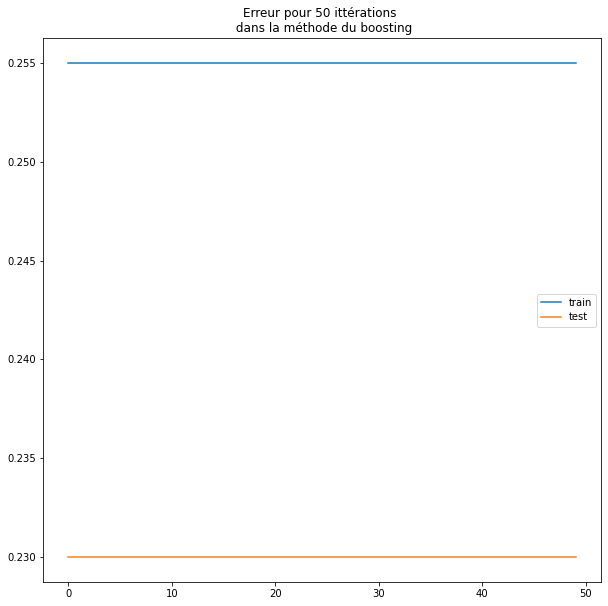

In [251]:


def boosting_tree_classifie(X_train,X_test,Y_train,Y_test,clf,it=10,display=True):
    n = len(Y_train) 
    Err_train = []
    Err_test = []
    
    Z = {f"{k}":[1/K for i in range(n)] for k in range(K)}
    RGT = {f"{k}": clf.fit(X_train,Z[f"{k}"]) for k in range(K)}

    
    
    for k in range(1,it+1):

        Y_pred_train = predictor(RGT,X_train)
        Y_pred_test = predictor(RGT,X_test)
        
        #Chargement de l'erreur de prédiction avec ce modèle Bootstrap
        Err_train.append(accuracy_score(Y_pred_train,Y_train))
        Err_test.append(accuracy_score(Y_pred_test,Y_test))
        
        #Fit des K arbres sur les "résidus"
        if k<it:
            for i in range(n):
                for k in range(K):
                    if Y_train[i]==k:
                        Z[f"{k}"][i] = 1-pi(k, [ Z[f"{k}"][i] for k in range(K)] )
                    else:
                        Z[f"{k}"][i] = -pi(k, [ Z[f"{k}"][i] for k in range(K)] )

            RGT = {f"{k}": clf.fit(X_train,Z[f"{k}"]) for k in range(K)}
            
               
    if display:
        plt.figure(figsize=(10,10))
        plt.plot(Err_train,label='train')
        plt.plot(Err_test,label='test')
        plt.title(f'Erreur pour {it} ittérations \n dans la méthode du boosting')
        plt.legend()
        plt.show()
        

clf = DecisionTreeRegressor(criterion='squared_error',max_depth=50) 
boosting_tree_classifie(X_train,X_test,Y_train,Y_test,clf,it=50,display=True) 

In [231]:
clf = DecisionTreeClassifier(criterion='entropy',max_depth=10,ccp_alpha=0.01)
boosting_tree_classifie(X_train,X_test,Y_train,Y_test,clf,it=10,eta=1,display=True) 

ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

# Alternative personnel au problème

In [190]:
def vote_majoritaire(matrice):
    modes = []
    for ligne in matrice:
        valeurs, compte = np.unique(ligne, return_counts=True)
        mode = valeurs[np.argmax(compte)]
        modes.append(mode)
    return np.array(modes).reshape((matrice.shape[0],1))


def bagging_weight_update(X_train,X_test,Y_train,Y_test,clf,it=10,display=True):
    models = {} #stocker les modèles à la suite
    n = len(Y_train)
    m = len(Y_test)
    Y_train = np.array(Y_train)
    Y_test = np.array(Y_test)
    Err_train = []
    Err_test = []
    W = np.ones(n)/n 
    
    #Initialisation:
    
    models[f'model{0}'] = clf.fit(X_train, Y_train,sample_weight=W)
    Y_pred_train = models[f'model{0}'].predict(X_train).reshape((n,1))
    Y_pred_test = models[f'model{0}'].predict(X_test).reshape((m,1))
    
    for k in tqdm(range(1,it+1)):
        models[f'model{k}'] = clf.fit(X_train, Y_train,sample_weight=W)

        # rajouter une colonne avec les nouvelles prédictions pour chaque ittération
        Y_pred_train = np.hstack(( Y_pred_train,models[f'model{k}'].predict(X_train).reshape((n,1)) ) )
        Y_pred_test = np.hstack((Y_pred_test,models[f'model{k}'].predict(X_test).reshape((m,1)) ) ) 

        #Principe du vote à la majorité sur chaque ligne
        YY_pred_train = vote_majoritaire(Y_pred_train)
        YY_pred_test = vote_majoritaire(Y_pred_test)
        
        #Chargement de l'erreur de prédiction avec ce modèle de bagging
        Err_train.append(1-accuracy_score(YY_pred_train,Y_train))
        Err_test.append(1-accuracy_score(YY_pred_test,Y_test))
        
        #Chargement des poids et attribution des des nouveaux poids
        if k<it:
            P = models[f'model{k}'].predict_proba(X_train)
            for i in range(n):
                W[i] = 1 - P[i,Y_train[i]]
                
    if display:
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        plt.plot(1-np.array(Err_train),label='train')
        plt.plot(1-np.array(Err_test),label='test')
        plt.title(f'Acurracy score pour {it} ittérations \n dans la méthode perso')
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(Err_train,label='train')
        plt.plot(Err_test,label='test')
        plt.title(f'Erreur pour {it} ittérations \n dans la méthode perso')
        plt.legend()
        plt.show()
        
 

### Avec différents types d'arbres

100%|██████████| 100/100 [00:04<00:00, 20.91it/s]


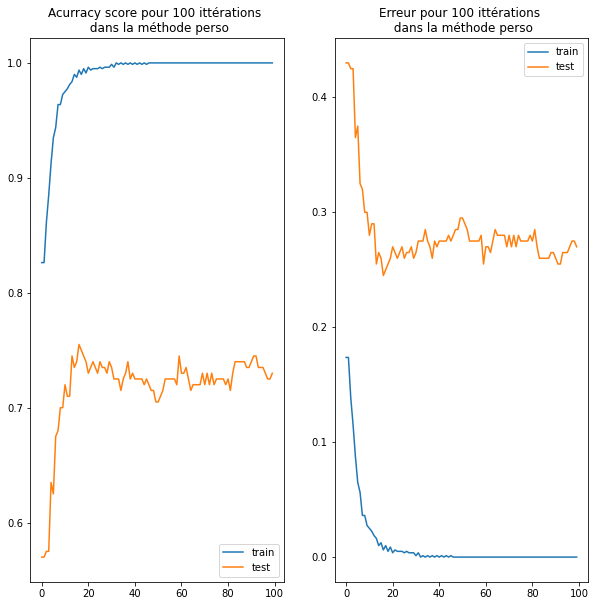

In [195]:
clf = DecisionTreeClassifier(criterion='entropy',max_depth=10,ccp_alpha=0.01)

bagging_weight_update(X_train,X_test,Y_train,Y_test,clf,it=100,display=True) 

100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


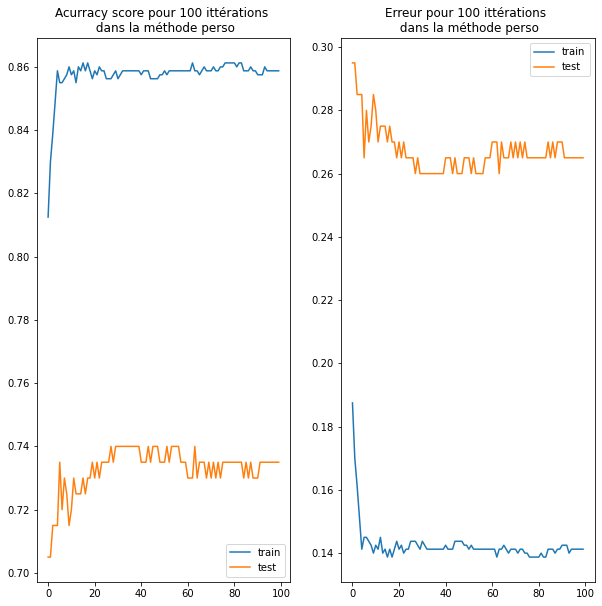

In [194]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(criterion='entropy',max_depth=50,ccp_alpha=0.03,n_estimators=200)
bagging_weight_update(X_train,X_test,Y_train,Y_test,clf,it=100,display=True)  

  0%|          | 0/70 [00:00<?, ?it/s]

100%|██████████| 70/70 [00:02<00:00, 25.09it/s]


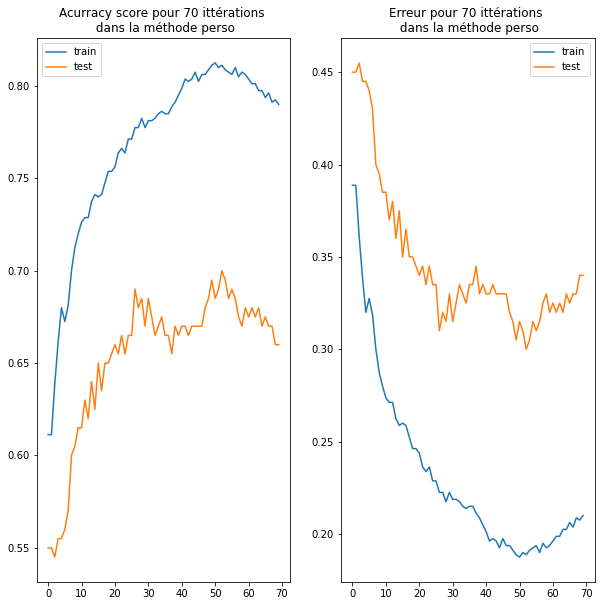

In [198]:
clf = DecisionTreeClassifier(criterion='gini',max_depth=10,ccp_alpha=0.01)

bagging_weight_update(X_train,X_test,Y_train,Y_test,clf,it=70,display=True) 

# Avec le jeu de données spam7.csv

In [199]:
path = '/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/TP2/spam7.csv'
df = pd.read_csv(path, sep=';')

#Attribution 0,1
df['yesno'] = df['yesno'].map({'y':1,'n':0})

X = df.drop(columns='yesno',axis=1)
Y = df['yesno']

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)

100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


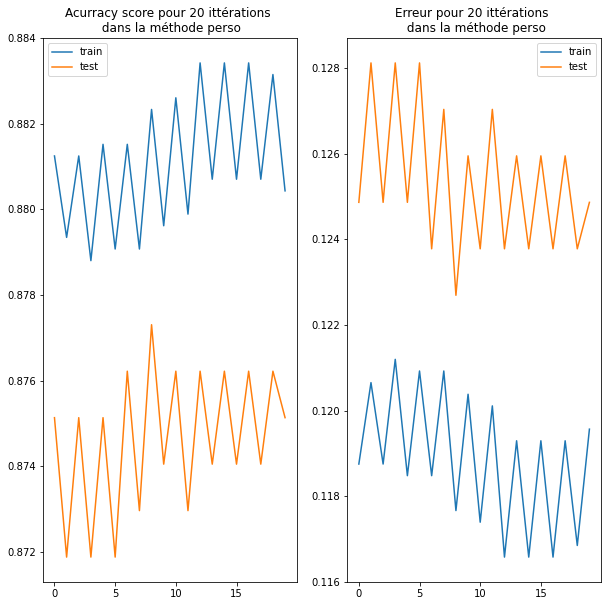

In [200]:
clf = RandomForestClassifier(criterion='entropy',max_depth=50,ccp_alpha=0.01,n_estimators=100)

bagging_weight_update(X_train,X_test,Y_train,Y_test,clf,it=20,display=True)
